In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import json

from glob import glob
import os

from importlib import reload
import persim

import utils
import collections
import umap

from sklearn import decomposition, preprocessing, manifold
from teaspoon.ML import feature_functions as Ff
TP = collections.namedtuple('TP', 'd delta epsilon')

/home/eah4d/.local/lib/python3.10/site-packages/numba/np/ufunc/parallel.py:371: NumbaWarning: The TBB threading layer requires TBB version 2021 update 6 or later i.e., TBB_INTERFACE_VERSION >= 12060. Found TBB_INTERFACE_VERSION = 12050. The TBB threading layer is disabled.
  warnings.warn(problem)


In [112]:
normtype = 'both'
level = 'sup'
n_components = 2
fs = 14; 
marker = ['D', '8', 's', '^', 'v', 'P', 'X', '*']
color = ['#56b4e9', '#f0e442', '#009e73', '#0072b2', '#d55e00', '#cc79a7', '#e69f00', '#f0e442', '#e0e0e0', '#000000']
cmap = ['Blues_r', 'Wistia', 'Greens_r', 'BuPu_r', 'Oranges_r', 'RdPu_r']

seed = 42
SCALE = 16
ndims = 3

wsrc = '../cell_dams/'
nsrc = '../nuclear_mask/'
tsrc = '../translocs/'
ksrc = '../kde/'
dst = '..' + os.sep + 'infected_focus_summer24' + os.sep 
sample = 'D2'

dst += sample + os.sep
ksrc += sample + os.sep

metacell = pd.read_csv(ksrc + sample + '_cells_metadata.csv')
metatrans = pd.read_csv(ksrc + sample + '_transcripts_metadata.csv')
transcell = pd.read_csv(ksrc + sample + '_transcells_metadata.csv')
transcriptomes = np.asarray(list(metatrans['gene']))

gsrc = '../{}level/'.format(level)
gsrc += sample + os.sep

Cells = utils.get_range_cell_values(dst + 'infected_cells_ids.csv', metacell, startval=1)
Genes = utils.get_range_gene_values(dst + 'genes_to_focus_infection.csv', transcriptomes, startval=0)
Genes = Genes[[0,-1]]

transfocus = transcell.loc[Genes, Cells.astype(str)]
ratios = utils.normalize_counts(transfocus, normtype)
if ratios is None:
    print('ERROR')

print('Max ratio by {}:\t{:.2f}%'.format(normtype, 100*np.max(ratios) ) )
transfocus

Max ratio by both:	0.25%


,742,842,2052,1145,896,2152,558,751,746,236,...,303,1782,1724,1571,1583,1454,2430,1143,752,513
85,363,1247,1026,572,938,1185,531,1819,984,1314,...,228,156,48,62,107,132,49,86,138,371
26,249,317,582,307,195,1026,529,687,341,694,...,439,406,187,183,271,241,62,152,396,806


In [164]:
print(np.sum(ratios > 0, axis=1))
jsonfiles = [ [ None for j in range(ratios.shape[1]) ] for i in range(ratios.shape[0]) ]
PP = 6
stepsize = 3
bw = 10

for i in range(len(jsonfiles)):
    foo = '{}{}/{}_-_{}_p{}_s{}_bw{}_c{:06d}.json'
    for j in range(len(jsonfiles[0])):
        filename = foo.format(gsrc, transcriptomes[Genes[i]],transcriptomes[Genes[i]],level,PP,stepsize,bw,Cells[j])
        if os.path.isfile(filename):
            jsonfiles[i][j] = filename

[968 968]


In [166]:
reload(utils)
minlife = 0.5
orig_diags = [ utils.get_diagrams(jsonfiles[i], ndims, remove_inf=True) for i in range(len(jsonfiles))]
orig_diags, rescale, maxlife, focus_dim = utils.normalize_persistence_diagrams(orig_diags, ratios, normtype, SCALE)
diags, nzcumsum, nzmask = utils.reduce_num_of_diagrams(orig_diags, rescale, focus_dim, normtype, minlife=minlife, keepall=False)
lt_coll, maxbirth = utils.birthdeath_to_flattened_lifetime(diags, nzcumsum[-1])

Initial number of life-birth pairs	: 113618

No. of diagrams s.t. H_k had the most persistent component
H_0:	1876 [ 96.9% ]
H_1:	60 [ 3.1% ]
H_2:	0 [ 0.0% ]

Will focus just on dimension k = 0

Non-zero diagrams:	1936
Compared to all diagrams:	1936	[100.00%]


# Template functions [Tents]

In [167]:
tent_params = TP(int(np.ceil(max([maxlife[:,:,focus_dim].max(), maxbirth]))), 1 ,0.1)
print([maxlife[:,:,focus_dim].max(), maxbirth])
tents = np.zeros((len(lt_coll), tent_params.d*(tent_params.d+1)))

for i in range(len(tents)):
    tents[i] = Ff.tent(lt_coll[i], tent_params, dgm_type='BirthLifetime')

[11.721061719984126, 14.05277007101534]


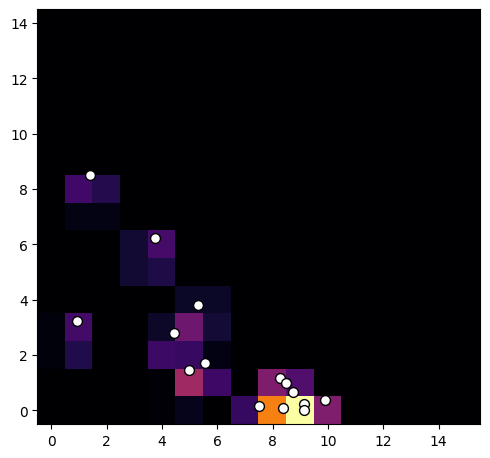

In [171]:
k = 1023
fig, ax = plt.subplots(1,1, figsize=(5,5), sharex=False, sharey=False)
ax = np.atleast_1d(ax).ravel(); i = 0

ax[i].imshow(tents[k].reshape(tent_params.d+1, tent_params.d).T, cmap='inferno', vmin=0, origin='lower')
ax[i].scatter(lt_coll[k][:,0], lt_coll[k][:,1]-0.5, c='w', marker='o', edgecolor='k', linewidth=1, s=50)

fig.tight_layout();

# Explore

[4.75627333 1.09446029]


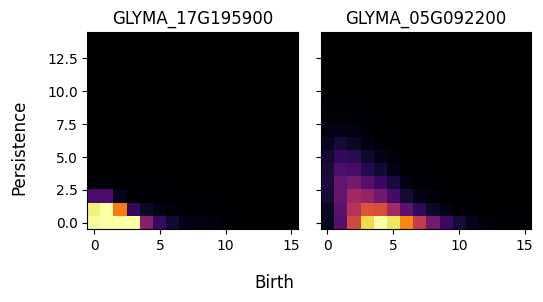

In [172]:
nrows, ncols = 1,2

avg = np.zeros( (len(nzcumsum) - 1, tent_params.d, tent_params.d+1))
for i in range(len(avg)):
    s_ = np.s_[nzcumsum[i]:nzcumsum[i+1]]
    avg[i] = np.mean(tents[s_], axis=0).reshape(tent_params.d+1, tent_params.d).T

print(np.max(avg, axis=(1,2)))
vmax = np.min(np.max(avg, axis=(1,2)))
fig, ax = plt.subplots(nrows, ncols, figsize=(2.75*ncols, 2.15*nrows+1), sharex=True, sharey=True)
ax = np.atleast_1d(ax).ravel()

for i in range(len(nzcumsum)-1):
    ax[i].imshow(avg[i], cmap='inferno', origin='lower', vmin=0, vmax=vmax)
    ax[i].set_title(transcriptomes[Genes[i]])

for i in range( len(ax) - len(nzcumsum)+1 , 0, -1):
    fig.delaxes(ax[-i])

fig.supxlabel('Birth', y=.04); 
fig.supylabel('Persistence')
fig.tight_layout()

# Reduce dimension

In [173]:
np.nonzero(maxpis > thr)[0]

array([1528])

19.0


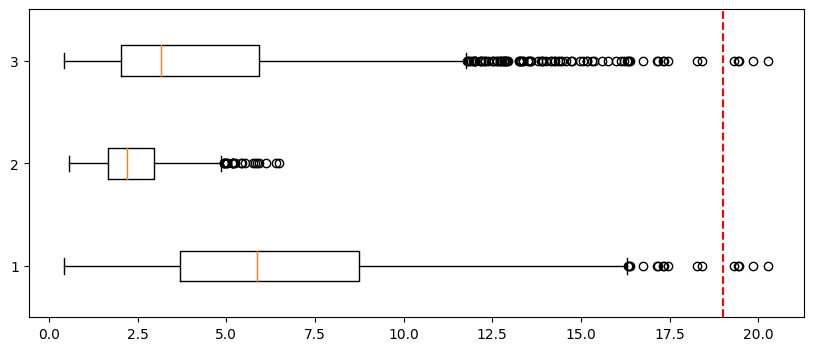

In [174]:
alpha = 0.2
iqr_factor = 1.5

maxpis = np.max(tents, axis=1)
boxes = [ maxpis[nzcumsum[i]:nzcumsum[i+1]] for i in range(len(Genes)) ] + [maxpis]
qq = np.asarray([ np.quantile(boxes[i], [alpha, 1-alpha]) for i in range(len(boxes)) ])
thr = np.ceil(np.max(qq[:,1] + iqr_factor*(qq[:,1] - qq[:,0])))

fig, ax = plt.subplots(1, 1, figsize=(10,4), sharex=True, sharey=True)
ax = np.atleast_1d(ax).ravel(); i = 0
ax[i].axvline(thr, c='r', ls='--', zorder=1)
ax[i].boxplot(boxes, vert=False, zorder=2);
print(thr)

maxmask = maxpis < thr
data = tents[maxmask].copy()
nz = np.hstack( ( [0], np.cumsum([ np.sum(maxmask[nzcumsum[i]:nzcumsum[i+1]]) for i in range(len(Genes)) ])))

In [175]:
def plot_embedding(embedding, alpha=0.05, title=None, nrows=2, ncols=4):
    q1, q3 = np.quantile(embedding[:,:2], [alpha, 1-alpha], axis=0)
    iqr = q3 - q1
    mn = np.maximum( q1 - 1.5*iqr, np.min(embedding[:,:2], axis=0) )
    mx = np.minimum( q3 + 1.5*iqr, np.max(embedding[:,:2], axis=0) )
        
    fig, ax = plt.subplots(nrows, ncols, figsize=(3*ncols,2*nrows+1), sharex=True, sharey=True)
    ax = np.atleast_1d(ax).ravel()
    
    for i in range(len(nz) - 1):
        ax[i].scatter(embedding[:,0], embedding[:,1], c='lightgray', marker='.', s=1, alpha=1, zorder=1)
        ax[i].set_facecolor('snow')
        s_ = np.s_[nz[i]:nz[i+1]]
        ax[i].scatter(embedding[s_,0], embedding[s_,1], c=color[i], marker=marker[i], alpha=0.25, zorder=2,
                      edgecolor='k', linewidth=0.5)
        ax[i].set_title(transcriptomes[Genes[i]])
        ax[i].set_xlim(mn[0],mx[0]);ax[0].set_ylim(mn[1],mx[1])
        ax[i].tick_params(left=False, labelleft=False, labelbottom=False, bottom=False);
    
    for i in range( len(ax) - len(nzcumsum)+1 , 0, -1):
        fig.delaxes(ax[-i])

    if title is not None:
        fig.supxlabel(title + ' 01')
        fig.supylabel(title + ' 02')
    
    return fig, ax

# PCA

In [176]:
PCA = decomposition.PCA(n_components=n_components, random_state=seed)
pca = PCA.fit_transform(data).astype('float32')
print(100*PCA.explained_variance_ratio_)

[51.70446504 19.85957187]


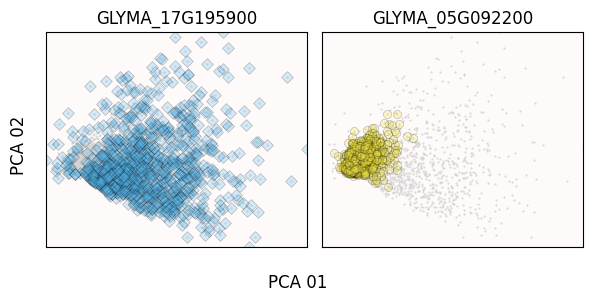

In [177]:
method = 'PCA'
bname = '{}'.format(method.lower())
# np.save(tdst+bname+'.npy', pca, allow_pickle=True)

fig, ax = plot_embedding(pca, 0.0, method, nrows=nrows, ncols=ncols)
fig.tight_layout();
#filename = tdst + bname
# plt.savefig(filename + '.png', dpi=dpi, bbox_inches='tight', format='png')

# KPCA

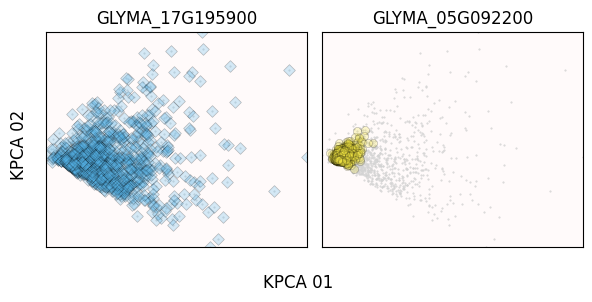

In [179]:
#params = {'kernel':'rbf', 'gamma':.01}
params = {'kernel':'poly', 'gamma':0.01, 'degree':2}
#params = {'kernel':'sigmoid', 'gamma':0.005}

KPCA = decomposition.KernelPCA(n_components=2, **params)
kpca = KPCA.fit_transform(data).astype('float32')

method = 'KPCA'; bname = '{}'.format(method.lower())

fig, ax = plot_embedding(kpca, 0.01, method, nrows=nrows, ncols=ncols)
fig.tight_layout();

# Locally Linear Embeddings

In [160]:
n_neighbors = 12  # neighborhood which is used to recover the locally linear structure
params = {"n_neighbors": n_neighbors,"n_components": 2, "eigen_solver": "auto","random_state": seed}
LLE = manifold.LocallyLinearEmbedding(method="standard", **params)
lle = LLE.fit_transform(data).astype('float32')

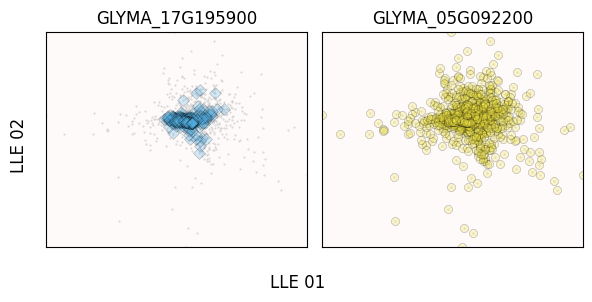

In [161]:
params = LLE.get_params()
method = 'LLE'
fig, ax = plot_embedding(lle, 0.0, method, nrows=nrows, ncols=ncols)
fig.tight_layout();

# Isomap

In [162]:
n_neighbors = 16  # neighborhood which is used to recover the locally linear structure
params = {"n_neighbors": n_neighbors,"n_components": 2,"eigen_solver": "auto"}
ISO = manifold.Isomap(**params)
iso = ISO.fit_transform(data).astype('float32')

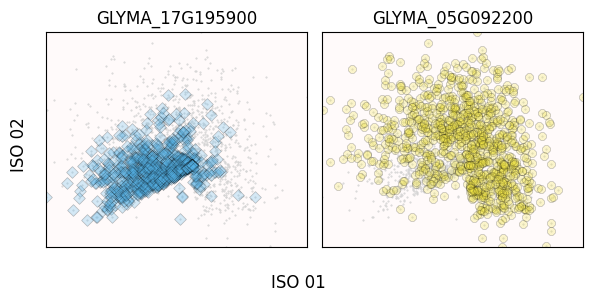

In [163]:
params = ISO.get_params()
method = 'ISO'
fig, ax = plot_embedding(iso, 0.0, method, nrows=nrows, ncols=ncols)
fig.tight_layout();

# tSNE

In [107]:
t_sne = manifold.TSNE(
    n_components=2,
    perplexity=25,
    init="random",
    n_iter=250,
    random_state=seed,
)
tsne = t_sne.fit_transform(data).astype('float32')

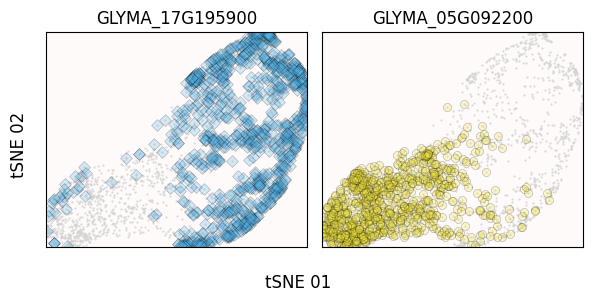

In [108]:
params = t_sne.get_params()
method = 'tSNE'

fig, ax = plot_embedding(tsne, 0.0, method, nrows=nrows, ncols=ncols)
fig.tight_layout();

# UMAP

In [109]:
ufit = umap.UMAP(n_neighbors=10, min_dist=0.25, n_components=2, metric='euclidean', random_state=seed, n_jobs=1)
u_umap = ufit.fit_transform(data);

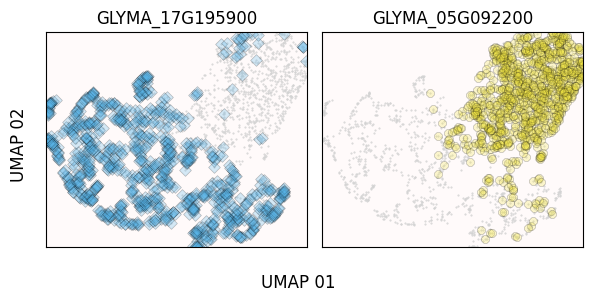

In [110]:
params = ufit.get_params();
method = 'UMAP'

fig, ax = plot_embedding(u_umap, 0.01, method, nrows=nrows, ncols=ncols)
fig.tight_layout();

# Match to Wasserstein distance

In [96]:
tdst = dst + bname + os.sep
if not os.path.isdir(tdst):
    os.mkdir(tdst)
print(tdst)

../infected_focus_summer24/D2/suplevel_-_by_both_-_sigma_4_-_pers+n_2_-_pixel+size_8/


In [60]:
import itertools
isrc = '..' + os.sep + 'infected_focus_summer24' + os.sep 
isrc += sample + os.sep

ws_o = 1
internal_p = np.inf
if internal_p == np.inf:
    ws_p = '\\infty'
else:
    ws_p = str(internal_p)

it = list(itertools.combinations(range(len(Genes)), 2))
columns = np.asarray([ '{}_-_vs_-_{}'.format(transcriptomes[Genes[foo[0]]],transcriptomes[Genes[foo[1]]]) for foo in it])
filename = isrc + 'wasserstein{}d_{}_-_{}level_-_by_{}'.format(ws_o, ws_p.replace('\\',''), level, normtype)

ws1 = pd.read_csv(filename + '.csv', index_col=0)
with open(filename + '.json') as f:
    dmatch = json.load(f)
print('Compared', len(dmatch), 'pairs of diagrams')
ws1.head()

Compared 10614 pairs of diagrams


,GLYMA_17G195900_-_vs_-_GLYMA_05G216000,GLYMA_17G195900_-_vs_-_GLYMA_17G185800,GLYMA_17G195900_-_vs_-_GLYMA_05G203100,GLYMA_17G195900_-_vs_-_GLYMA_15G210100,GLYMA_17G195900_-_vs_-_GLYMA_05G092200,GLYMA_05G216000_-_vs_-_GLYMA_17G185800,GLYMA_05G216000_-_vs_-_GLYMA_05G203100,GLYMA_05G216000_-_vs_-_GLYMA_15G210100,GLYMA_05G216000_-_vs_-_GLYMA_05G092200,GLYMA_17G185800_-_vs_-_GLYMA_05G203100,GLYMA_17G185800_-_vs_-_GLYMA_15G210100,GLYMA_17G185800_-_vs_-_GLYMA_05G092200,GLYMA_05G203100_-_vs_-_GLYMA_15G210100,GLYMA_05G203100_-_vs_-_GLYMA_05G092200,GLYMA_15G210100_-_vs_-_GLYMA_05G092200
ndimage_ID,,,,,,,,,,,,,,,
742,118.959835,NaN,NaN,133.539224,327.996576,NaN,NaN,28.259547,223.314988,NaN,NaN,NaN,NaN,NaN,230.633373
842,310.153086,292.168918,NaN,317.498865,444.566202,56.462265,NaN,20.894739,271.381668,NaN,60.926221,252.530425,NaN,NaN,279.565037
2052,297.745725,289.535611,NaN,292.478642,533.569414,34.595498,NaN,18.470045,317.790741,NaN,19.881242,311.551000,NaN,NaN,312.523658
1145,240.893439,200.288864,180.552672,203.936608,184.418852,48.387111,64.030185,54.227541,253.380191,21.471638,37.478485,212.775616,29.454654,193.039424,216.423360
896,260.494339,267.688913,NaN,253.817726,196.561986,91.130656,NaN,32.228374,243.670121,NaN,81.592263,250.864695,NaN,NaN,236.993509


In [140]:
gi, gj = 0,1
foo = '{}_-_vs_-_{}'.format(transcriptomes[Genes[gi]], transcriptomes[Genes[gj]])
print(foo)
diff = ws1[foo]

alpha = 0.025

vmin,vmax = np.quantile(diff.values, [alpha,1-alpha])
q1, q3 = np.quantile(diff.values, [0.25, 0.75])
iqr = q3 - q1

vmin = max([diff.min(), q1-iqr])
vmax = min([diff.max(), q3+iqr])

GLYMA_17G195900_-_vs_-_GLYMA_05G092200


In [185]:
embedding = u_umap.copy()

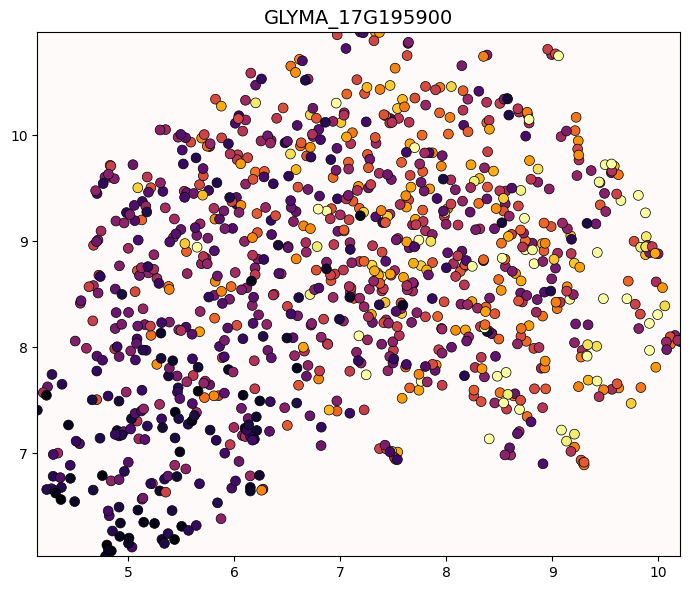

In [186]:
fig, ax = plt.subplots(1, 1, figsize=(7,7), sharex=True, sharey=True); ticks = False
ax = np.atleast_1d(ax).ravel(); i = 0

ax[i].scatter(embedding[:,0], embedding[:,1], c=diff.values, marker='o', cmap = 'inferno',
              edgecolor='k', linewidth=0.5, alpha=1, zorder=2, s=50, vmin=vmin, vmax=vmax)
ax[i].set_facecolor('snow')
ax[i].set_title(transcriptomes[Genes[jx]], fontsize=fs)
#ax[i].tick_params(left=ticks, labelleft=ticks, labelbottom=ticks, bottom=ticks);
ax[i].margins(0)
ax[i].set_aspect('equal')

fig.tight_layout();

In [194]:
N = 25
bins = np.linspace(embedding[:,0].min(), embedding[:,0].max(), N)
bins[-1] += 1
digitize = np.digitize(embedding[:,0], bins)
aux = np.zeros((len(bins)-1, 4))

for i in range(len(aux)):
    foo = diff.values[digitize == i+1]
    bar = [i, bins[i], np.min(foo), np.median(foo), np.mean(foo), np.max(foo)]
    aux[i] = bar[2:]
    print('{:02d}\t{:.2f}\t{:.2f}\t{:.2f}\t{:.2f}'.format(*bar) )

00	4.15	35.36	134.02	160.81
01	4.40	70.22	202.50	215.93
02	4.65	38.44	229.99	240.24
03	4.90	54.55	214.48	235.30
04	5.15	59.09	233.26	265.11
05	5.41	31.33	213.56	240.34
06	5.66	41.01	318.75	338.27
07	5.91	62.67	288.27	278.01
08	6.16	72.07	288.31	299.48
09	6.42	66.91	313.08	347.84
10	6.67	87.10	338.27	391.06
11	6.92	91.23	376.31	382.15
12	7.17	73.06	434.77	441.95
13	7.43	82.64	388.58	411.12
14	7.68	156.39	418.11	435.46
15	7.93	114.81	396.45	396.16
16	8.18	106.57	404.12	435.98
17	8.44	96.87	416.20	464.71
18	8.69	187.72	484.06	486.00
19	8.94	123.23	394.30	455.62
20	9.19	116.17	543.46	538.69
21	9.45	293.31	481.81	529.65
22	9.70	268.70	655.59	644.41
23	9.95	225.05	406.12	458.75


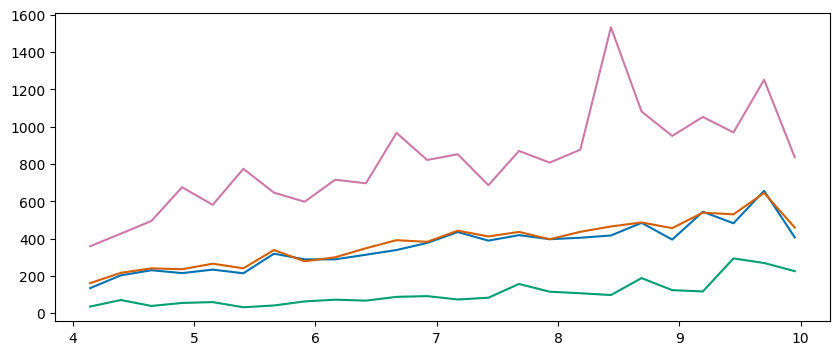

In [195]:
fig, ax = plt.subplots(1, 1, figsize=(10,4), sharex=True, sharey=True); ticks = False
ax = np.atleast_1d(ax).ravel(); i = 0

for j in range(aux.shape[1]):
    ax[i].plot(bins[:-1], aux[:,j], color=color[j+2])